# Introduction

Heart disease is a leading cause of death. Angiography (the definitive test) is invasive, expensive, and takes time. 

**The Pain Point**: Doctors need a quick, non-invasive way to assess if a patient likely has hear disease so they can prioritze them for treatment.
**The Question**: *"Can we estimate the likelihood of a patient having heart disease based on basic clinical data (like age, chest pain type, and max heart rate)?"*

---

**Learning Approach: Supervised Learning**
**Technique: Binary Classification**
**Objective: Recall (Sensitivity)**
* I want **High Recall**. In medicine, it is better to falsely alarm a healthy person (False Positive) than to miss a sick person (False Negative).

---

**Project Definition Summary**
* **Input (Features)** : Age, Sex, CP (Chest Pain), Trestbps (Blood Pressure), Chol (Cholesterol), etc.
* **Output (Target)** : `target` (1 = Heart Disease, 0 = Healthy)
* **Task** : Train a model to classify patients into these two groups.
* **Evaluation** : Primary -> **Recall** (Catching the disease). Secondary -> **Accuracy**

---

# Import Libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import kagglehub
from kagglehub import KaggleDatasetAdapter
import warnings
warnings.filterwarnings('ignore')

---

# Load Dataset

In [4]:
# Set the path to the file you'd like to load
path = kagglehub.dataset_download("neurocipher/heartdisease")

print(path)

100%|██████████| 3.41k/3.41k [00:00<00:00, 2.27MB/s]

Extracting files...
/Users/azhar/.cache/kagglehub/datasets/neurocipher/heartdisease/versions/1


In [8]:
import os

os.listdir(path)

data = pd.read_csv(f"{path}/Heart_Disease_Prediction.csv")

data.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


In [11]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    object 
dtypes: float64(1), int64(12), 

In [12]:
print(data.iloc[:, -1].value_counts())

Heart Disease
Absence     150
Presence    120
Name: count, dtype: int64


# Preprocessing

In [16]:
# Standardize column names
data.columns = data.columns.str.lower().str.replace(' ', '_')

# Convert target column to binary (1/0)
target_col = 'heart_disease'
data[target_col] = data[target_col].map({'Presence': 1, 'Absence': 0})

# verify
print(data[target_col].value_counts())

heart_disease
0    150
1    120
Name: count, dtype: int64


`cp` (Chest Pain) column has values `0,1,2,3`.
* The Problem: This column is a categorical, if i feed this directly into a model the math assumes that `type 3` pain is "worth 3 times" than `type 1` pain.
* The Reality: They are just different types of pain. There is no "order".

Because of that, i must encode this column first.

In [27]:
data.head()

,age,sex,chest_pain_type,bp,cholesterol,fbs_over_120,ekg_results,max_hr,exercise_angina,st_depression,slope_of_st,number_of_vessels_fluro,thallium,heart_disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0


In [28]:
# Seperate the categorical vs numeric columns
categorical_cols = ['chest_pain_type', 'slope_of_st', 'thallium', 'ekg_results']

# One-hot encoding
df_clean = pd.get_dummies(data, columns = categorical_cols, drop_first=True)

---

# EDA (Exploratory Data Analysis)

* **Does Age matter?** (Are older people more likely to get it?)
* **Does Max Heart Rate matter?** (Is a lower max heart rate a bad sign?)

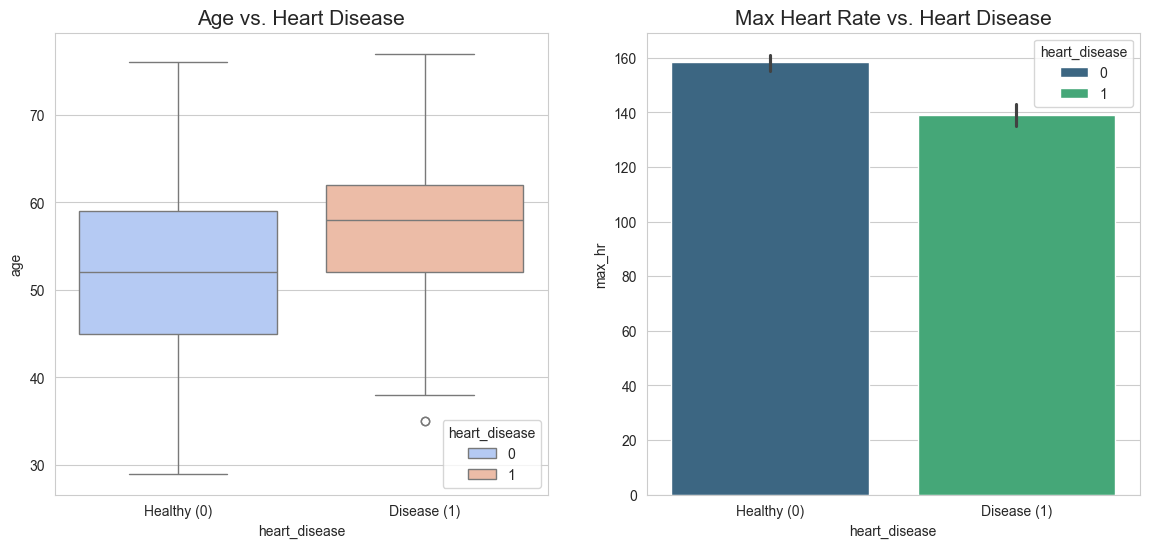

In [30]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(1, 2, figsize=(14,6))

# Age vs. Heart Disease
sns.boxplot(ax=ax[0], x=target_col, y='age', data=df_clean, palette='coolwarm', hue=target_col)
ax[0].set_title("Age vs. Heart Disease", fontsize=15)
ax[0].set_xticklabels(['Healthy (0)', 'Disease (1)'])

# Max Heart Rate vs. Heart Disease
max_hr_col = 'max_hr'

sns.barplot(ax=ax[1], data=df_clean, x=target_col, y=max_hr_col, palette='viridis', hue=target_col)
ax[1].set_title('Max Heart Rate vs. Heart Disease', fontsize=15)
ax[1].set_xticklabels(['Healthy (0)', 'Disease (1)'])

plt.show()

In [31]:
# Define Features (X) and Target (y)
X = df_clean.drop('heart_disease', axis=1)
y = df_clean['heart_disease']

# Split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Scale the data
# Fit the scaler only on the training data to prevent "data leakage"
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training Shape: {X_train_scaled.shape}")
print(f"Test Shape: {X_test_scaled.shape}")

Training Shape: (216, 18)
Test Shape: (54, 18)


---

# Modeling & Evaluation

1. Logistic Regression:
    * Simple, fast, and explains "Risk Factors" (e.g., "For every 1 unit increase in Age, odds of disease go up by X%)

2. Random Forest:
    * Handles complex, non-linear relationships (e.g., "High cholestrol is only bad if Age > 50") better than regression.

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Model 1: Logistic Regression
log_model = LogisticRegression()
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)

print("=== LOGISTIC REGRESSION REPORT ===")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_log)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_log)}")

=== LOGISTIC REGRESSION REPORT ===
Confusion Matrix:
[[32  1]
 [ 6 15]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90        33
           1       0.94      0.71      0.81        21

    accuracy                           0.87        54
   macro avg       0.89      0.84      0.86        54
weighted avg       0.88      0.87      0.87        54



In [39]:
# Model 2: Random Forest

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

print("=== RANDOM FOREST REPORT ===")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_log)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_log)}")

=== RANDOM FOREST REPORT ===
Confusion Matrix:
[[32  1]
 [ 6 15]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90        33
           1       0.94      0.71      0.81        21

    accuracy                           0.87        54
   macro avg       0.89      0.84      0.86        54
weighted avg       0.88      0.87      0.87        54



`Precission` is high, but `Recall` is quite low and miss 6 patients who actually has heart disease (bad news). **This is still unacceptable for a screening tool**.

# Optimizing for Safety

Right now, the model uses a default cutoff of 50% (0.5).
* Probability > 0.5 -> "Sick"
* Probability < 0.5 -> "Healthy"

To catch those 6 missing patients, i need to be more "paranoid". I should lower the bar. If the model is even 20% or 30% suspicious, we should flag them for a checkup.

Let's lower the threshold to 0.3 (30%) and see if we can cath those 6 people.

In [42]:
from sklearn.metrics import recall_score, accuracy_score

# Get the probability scores (instead of just 0/1)
y_pred_prob = log_model.predict_proba(X_test_scaled)[:, 1]

# Set a lower threshold (be more paranoid)
threshold = 0.3 # If > 30% chance of disease, flag as Positive
y_pred_new = (y_pred_prob > threshold).astype(int)

# Check the new results
print(f"--- THRESHOLD: {threshold} ---")
print("New Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_new))

print("\nNew Recall Score:")
print(recall_score(y_test, y_pred_new))

print("\nNew Accuracy:")
print(accuracy_score(y_test, y_pred_new))

--- THRESHOLD: 0.3 ---
New Confusion Matrix:
[[28  5]
 [ 3 18]]

New Recall Score:
0.8571428571428571

New Accuracy:
0.8518518518518519


---

#### THE ROC CURVE
Plot a curve called the **ROC Curve (Receiver Operating Characteristic)** to see every possible threshold at once.

* Top Left Corner: The perfect model (100% Recall, 0 False Alarms).
* The Curve: Shows you exactly how much "False Alarm" pain you have to accept to get "High Recall" gain.

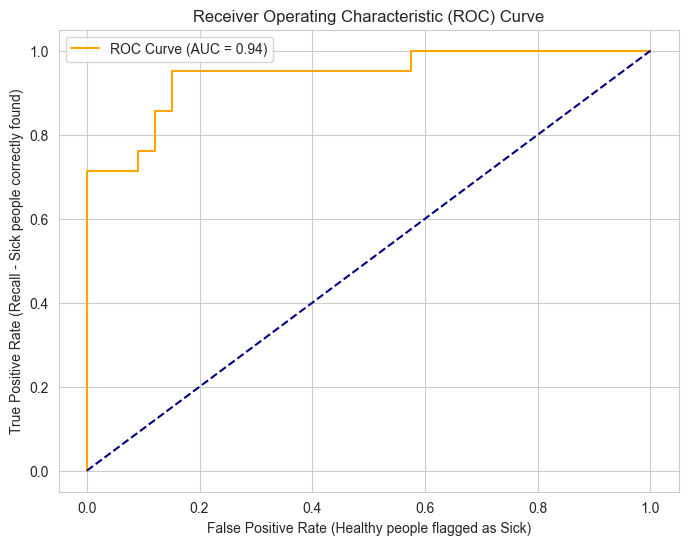

In [44]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the False Positive Rate (fpr) and True Positive Rate (tpr)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC Score (Area Under Curve) - 1.0 is perfect, 0.5 is random guession
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='orange', label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0,1], [0,1], color='navy', linestyle='--') # random guess line
plt.xlabel('False Positive Rate (Healthy people flagged as Sick)')
plt.ylabel('True Positive Rate (Recall - Sick people correctly found)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()



---

In [ ]:
# Save the dataset
df_clean.to_csv('heart_disease_clean.csv', index=False)

In [46]:
import pickle

# Save the model
# Create a dictionary to bundel the model and the scaler together
saved_data = {
    "model": log_model,
    "scaler": scaler
}

# Open a file in 'wb' mode (Write Binary)
with open('heart_disease_model.pkl', 'wb') as file:
    pickle.dump(saved_data, file)